## Part 1 ‐ Exploratory data analysis

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
logins = pd.read_json('logins.json', orient='columns')
logins.tail()

,login_time
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38
93141,1970-04-13 18:54:23


In [11]:
logins['count'] = 1
chart = logins.set_index('login_time')
by15 = chart.resample('15T', how='sum')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
logins.head()

,login_time,count
0,1970-01-01 20:13:18,1
1,1970-01-01 20:16:10,1
2,1970-01-01 20:16:37,1
3,1970-01-01 20:16:36,1
4,1970-01-01 20:26:21,1


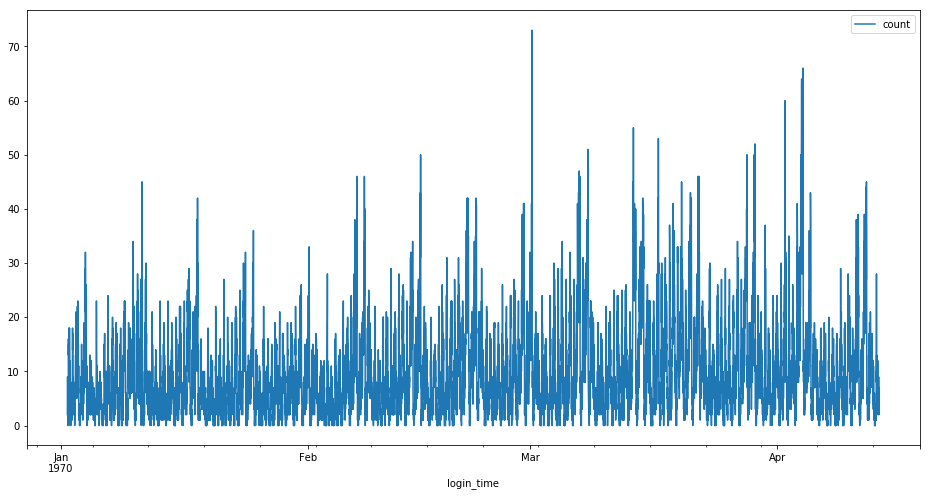

In [13]:
by15.plot(figsize=(16,8))

### 15 minute intervals already show us an interesting cyclical pattern of highs and valleys of login figures.
### moving onto explore these accross specific time in a day

In [14]:
byhour = by15.groupby([by15.index.hour, by15.index.minute]).sum()

In [15]:
byhour.index= byhour.index.map('{0[0]}:{0[1]}'.format)
byhour.head()

,count
0:0,1439
0:15,1547
0:30,1525
0:45,1482
1:0,1549


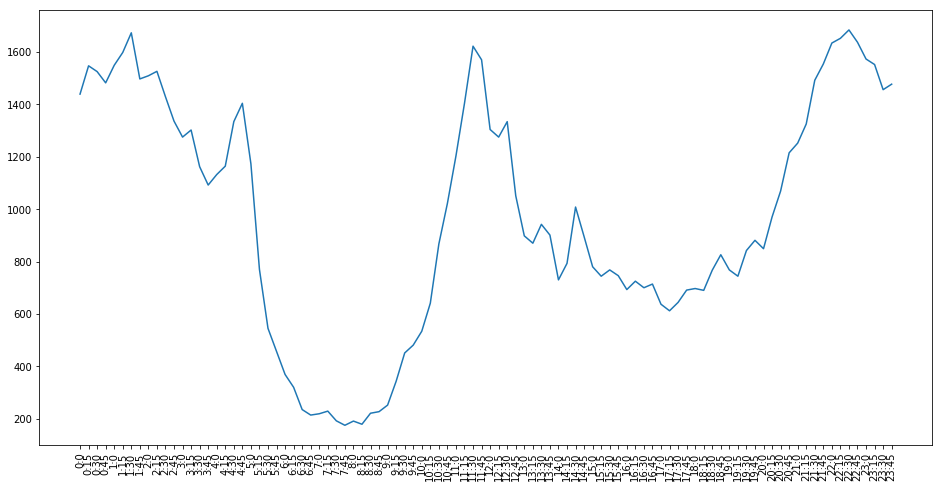

In [16]:
plt.figure(figsize=(16,8))
plt.plot(byhour.index.values, byhour['count'])
plt.xticks(rotation=90)
plt.show()

### There are two clear drops in logins - in the morning hours and again in the afternoon. Something must be happening arounfd noon that brings the logins back to the levels that we see at night.

            count
login_time       
Friday      15208
Monday       8823
Saturday    19377
Sunday      18167
Thursday    11960
Tuesday      9268
Wednesday   10339


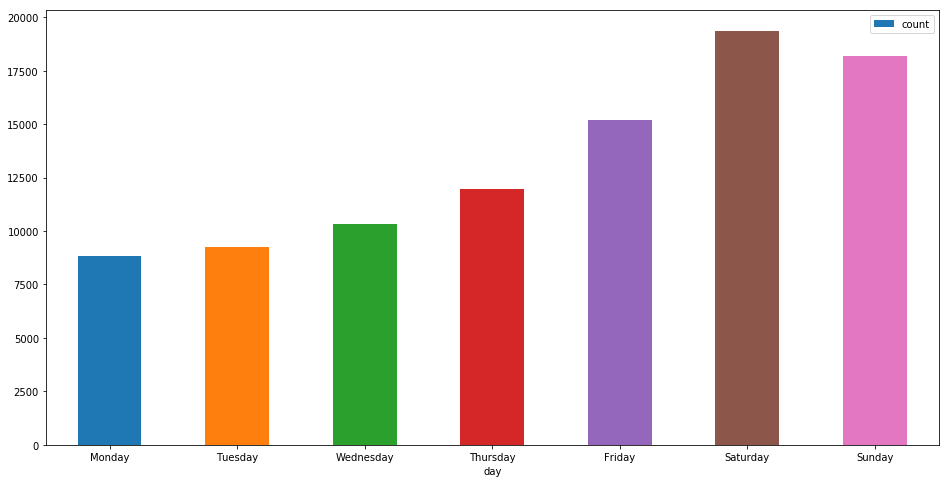

In [17]:
week_df = logins.groupby(logins['login_time'].dt.weekday_name).sum()
print (week_df)
week_df['day'] = week_df.index

cmap =  {'Monday':0,'Tuesday':1, 'Wednesday':2,'Thursday':3, 'Friday':4, 'Saturday':5, 'Sunday':6}
week_df['num_day'] = week_df['day'].map(cmap)
week_df.sort_values('num_day', inplace=True)

week_df.plot.bar(x='day', y='count', rot=0, figsize=(16,8))
plt.show()

### Clear peak of logins on the weekend

## Part 2 ‐ Experiment and metrics design

### Experiement metric: Since this is a question of balancing out the supply of drivers (taxis) and the demand for rides, a good berometer for success would be the time that a rides needs to wait for a ride to come pick her up.

### A driver that finds himself/herself in Gotham would have previosuly been discouraged by crossing the bridge because of the cost. With the cost our of the picture, a driver that makes their way accross to where there is more demand would signify a successful behavior in the experiment.

### The experiemnt would look at previous grouped data from riders in various metro regions by region and by time-stamp (every 15 minutes or an hour). The mean wait time for a ride would be calculated. 

### Subsequently, for the duration of the experiement, the same metrics would be measured in the same regions and in the same time intervals. The top level comparison would look at the average wait times in the two time periods and see whether there was a statistically significant difference (T-test or ANOVA). 


### Caveats to consider:
### * since we are not doing the experiement at the samer time, we must account for other factors that could affect ridership between the two periods. 
### * There could be other preferances beyond price that have drivers want to be in one city over another - e.g. attitude of drivers or condition of roads.
### * There would need to be a consideration for volume of rides request as that has a major effect on the time waited. Similarly, we would want to account for traffic in the area.


### Second experiement variation to address some of these caveats:
### A split test, in which only some percentage of the drivers are given the incentive to cross the bridge by covering their costs. In that case, the wait time metric could be used if we could compare those who had the incentize vs those who did not. Another metric that we could use is the avergage number of passengers served by incentivized drivers vs those who were not incentivized. Given that drivers have different patterns by which they drive, it would be improtant to look at the ratio of drivers before and after the incentive for those incentivized drivers and comapre it to the ratio of pre-and post incentive for the non-incentivized drivers. 

### An increased ratio of drivers served for incentivized drivers would mean that the incentives were related with an increased ability to serve more riders. I would therefore recommend the city operations team to lower or eliminate the tolls for drivers if the goal is to increase the flow of drivers between the cities. Ultimately, since this is a business decision, we would need to compare the revenues brought in by the increased ridership and the costs that covering the tolls resulted in. This would be an important caveat in the ultimate decision to continue to incentivize drivers. For example, while a statistically significant ridership difference could be two extra rides on average, this increase could still be a fraction of the costs that were used to cover the tolls.

## Part 3 ‐ Predictive modeling

In [48]:
import json

with open('ultimate_data_challenge.json') as f:
   data = json.load(f)
df = pd.DataFrame(data)
df.tail()
#df = pd.read_json('ultimate_data_challenge.json', orient='records')
#df.tail()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
49995,5.63,4.2,5.0,1.0,King's Landing,2014-06-05,iPhone,2014-01-25,0.0,0,False,100.0
49996,0.00,4.0,NaN,1.0,Astapor,2014-01-25,iPhone,2014-01-24,0.0,1,False,0.0
49997,3.86,5.0,5.0,1.0,Winterfell,2014-05-22,Android,2014-01-31,0.0,0,True,100.0
49998,4.58,3.5,3.0,1.0,Astapor,2014-01-15,iPhone,2014-01-14,0.0,2,False,100.0
49999,3.49,5.0,NaN,1.0,Astapor,2014-04-20,Android,2014-01-18,0.0,0,False,0.0


In [49]:
max(df.last_trip_date)

'2014-07-01'

In [50]:
#Creating target variable ('retained') - marked at '1' if rode in past month. Otherwise '0'
#assuming the latest trip was around the time the report was pulled
 
from datetime import datetime
datetime_object = datetime.strptime('Jun 1 2014', '%b %d %Y')
df['retained'] = 0
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
for index, row in df.iterrows():
     if row['last_trip_date'] > datetime_object:
            df.set_value(index,'retained',1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.


In [51]:
df.tail()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained
49995,5.63,4.2,5.0,1.0,King's Landing,2014-06-05,iPhone,2014-01-25,0.0,0,False,100.0,1
49996,0.00,4.0,NaN,1.0,Astapor,2014-01-25,iPhone,2014-01-24,0.0,1,False,0.0,0
49997,3.86,5.0,5.0,1.0,Winterfell,2014-05-22,Android,2014-01-31,0.0,0,True,100.0,0
49998,4.58,3.5,3.0,1.0,Astapor,2014-01-15,iPhone,2014-01-14,0.0,2,False,100.0,0
49999,3.49,5.0,NaN,1.0,Astapor,2014-04-20,Android,2014-01-18,0.0,0,False,0.0,0


In [52]:
df.columns[df.isna().any()].tolist()

['avg_rating_by_driver', 'avg_rating_of_driver', 'phone']

In [53]:
df['phone'].fillna('unknown', inplace=True)

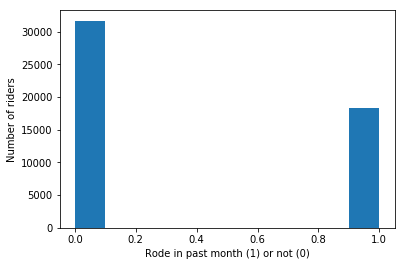

Percentage of those who rode in the past month from Jan registrants is 36.62% 


In [54]:
# Histogram of those who rode in past month vs those who didnt

plt.hist(df['retained'])
plt.xlabel('Rode in past month (1) or not (0)')
plt.ylabel('Number of riders')
plt.show()
print ("Percentage of those who rode in the past month from Jan registrants is {:0.2f}% ".format(sum(df['retained'])/len(df)*100))

In [55]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0


In [56]:
df['ultimate_black_user'] = df['ultimate_black_user'].astype(str) + '_black'

In [57]:
df.columns

Index(['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'city', 'last_trip_date', 'phone', 'signup_date', 'surge_pct',
       'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct',
       'retained'],
      dtype='object')

In [58]:
# One Hot Encoding
df = df.join(pd.get_dummies(df.city)).drop("city", axis=1)
df = df.join(pd.get_dummies(df.phone)).drop("phone", axis=1)
df = df.join(pd.get_dummies(df.ultimate_black_user), ).drop("ultimate_black_user", axis=1)
df = df.drop("False_black", axis=1)
df = df.drop("unknown", axis=1)
df = df.drop("Astapor", axis=1)

df_no_dates = df.drop("last_trip_date", axis=1)
df_no_dates = df_no_dates.drop("signup_date", axis=1)

In [60]:
df_no_dates = df.drop("last_trip_date", axis=1)
df_no_dates = df_no_dates.drop("signup_date", axis=1)

In [61]:
grpd = df_no_dates.groupby('retained').mean()
grpd.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,King's Landing,Winterfell,Android,iPhone,True_black
retained,,,,,,,,,,,,
0,6.188478,4.786876,4.607018,1.075367,8.688548,1.659167,60.181597,0.120637,0.484538,0.381193,0.610413,0.299621
1,5.118977,4.763121,4.593364,1.073720,9.128165,3.349590,62.214604,0.344457,0.435882,0.160677,0.832223,0.511141


### Some intial observations from a Groupby on the Target variable of having taken a ride on the past 30 days:

### * Those that are used the service in the past 30 rode over twice as much in the first 30 days of using the service
### * Much greater percentage of those using the service in past 30 days are in King's Landing
### * Of those that are using the app, 83% are iphone users as opposed to 61% for those who did not retain the service
### * Of those that used the ride service in the past 30 days, 50% used the ultimate black service in the past. This is compared to 30% of those who did not use the service in the past 30 days

In [62]:
df_reg = df_no_dates.fillna(df.mean()).dropna(axis=1, how='all')

In [63]:
df_reg.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,retained,King's Landing,Winterfell,Android,iPhone,True_black
0,3.67,5.0,4.7,1.10,15.4,4,46.2,1,1,0,0,1,1
1,8.26,5.0,5.0,1.00,0.0,0,50.0,0,0,0,1,0,0
2,0.77,5.0,4.3,1.00,0.0,3,100.0,0,0,0,0,1,0
3,2.36,4.9,4.6,1.14,20.0,9,80.0,1,1,0,0,1,1
4,3.13,4.9,4.4,1.19,11.8,14,82.4,0,0,1,1,0,0


In [92]:
from sklearn.model_selection import train_test_split

df_reg.reset_index(drop=True)

X = df_reg.drop(['retained'], axis=1)
y = df_reg['retained']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [65]:
def run_regression_accuracy(X_train, y_train, X_test, y_test):
  logreg = LogisticRegression()
  logreg.fit(X_train, y_train)
  y_pred = logreg.predict(X_test)
  print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
  cm = confusion_matrix(y_test, y_pred)
  print('\nConfusion matrix: \n',cm)

  print('\nClassification report: \n',classification_report(y_test, y_pred))

  logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
  fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])

  plt.figure()
  plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.savefig('Log_ROC')
  plt.show()
  
  return logreg

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of logistic regression classifier on test set: 0.72

Confusion matrix: 
 [[8091 1432]
 [2742 2735]]

Classification report: 
               precision    recall  f1-score   support

           0       0.75      0.85      0.79      9523
           1       0.66      0.50      0.57      5477

   micro avg       0.72      0.72      0.72     15000
   macro avg       0.70      0.67      0.68     15000
weighted avg       0.71      0.72      0.71     15000



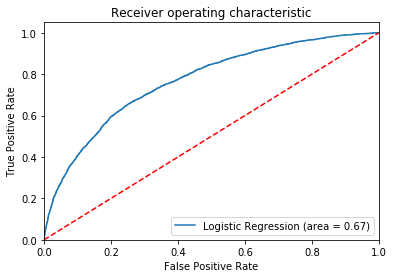

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

logreg = run_regression_accuracy(X_train, y_train, X_test, y_test)

In [67]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

def iterate_vif(df, vif_threshold=5, max_vif=6):
  count = 0
  while max_vif > vif_threshold:
    count += 1
    print("Iteration # "+str(count))
    vif = pd.DataFrame()
    vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif["features"] = df.columns
    
    if vif['VIFactor'].max().round(1) > vif_threshold:
      print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max().round(1)))
      df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
      max_vif = vif['VIFactor'].max().round(1)
    else:
        print('Complete')
        return df, vif.sort_values('VIFactor').round(1)

final_df, final_vif = iterate_vif(X_train)

Iteration # 1
Removing avg_rating_by_driver with VIF of 85.100000
Iteration # 2
Removing avg_surge with VIF of 50.600000
Iteration # 3
Removing avg_rating_of_driver with VIF of 45.400000
Iteration # 4
Removing iPhone with VIF of 5.600000
Iteration # 5
Complete


In [71]:
X_train=final_df
X_test = X_test[X_train.columns]

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of logistic regression classifier on test set: 0.72

Confusion matrix: 
 [[8081 1442]
 [2754 2723]]

Classification report: 
               precision    recall  f1-score   support

           0       0.75      0.85      0.79      9523
           1       0.65      0.50      0.56      5477

   micro avg       0.72      0.72      0.72     15000
   macro avg       0.70      0.67      0.68     15000
weighted avg       0.71      0.72      0.71     15000



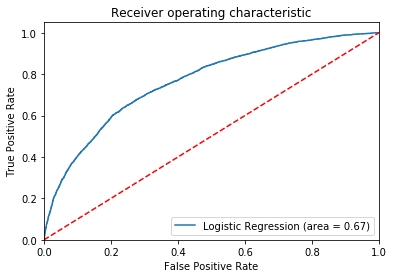

In [72]:
logreg = run_regression_accuracy(X_train, y_train, X_test, y_test)

In [73]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.547256
         Iterations 6
                            Results: Logit
Model:                Logit              Pseudo R-squared:   0.167     
Dependent Variable:   retained           AIC:                54749.5980
Date:                 2019-06-05 11:53   BIC:                54855.4353
No. Observations:     50000              Log-Likelihood:     -27363.   
Df Model:             11                 LL-Null:            -32845.   
Df Residuals:         49988              LLR p-value:        0.0000    
Converged:            1.0000             Scale:              1.0000    
No. Iterations:       6.0000                                           
-----------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
avg_dist               -0.0368   0.0021 -17.4959 0.0000 -0.0409

In [93]:
from sklearn.metrics import roc_auc_score

# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 250 decision trees
rf = RandomForestClassifier(random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train)

X_test = X_test[X_train.columns.tolist()] # Added to refelct the column count

y_pred2 = rf.predict(X_test)

roc2 = roc_auc_score(y_test, y_pred2)

roc2

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.7182634871234458

In [94]:
conf2 = confusion_matrix(y_test, y_pred2)
conf2

array([[7904, 1619],
       [2155, 3322]])

In [79]:
len(df_reg) - sum(df_reg.retained)

31690

In [88]:
#upsampling as our current ratio of 1 to 0 is only .3 
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df_reg[df_reg.retained==0]
df_minority = df_reg[df_reg.retained==1]
 
# Downsample majority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample without replacement
                                 n_samples=31690,     # to match minority class
                                 random_state=42) # reproducible results
 
# Combine minority class with downsampled majority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority])
 
# Display new class counts
df_upsampled.retained.value_counts()

1    31690
0    31690
Name: retained, dtype: int64

In [96]:
X = df_upsampled.drop(['retained'], axis=1)
y = df_upsampled['retained']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Instantiate model with 250 decision trees
rf = RandomForestClassifier(random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train)

X_test = X_test[X_train.columns.tolist()] # Added to refelct the column count

y_pred2 = rf.predict(X_test)

roc2 = roc_auc_score(y_test, y_pred2)

roc2

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.84562325156406

In [97]:
conf2 = confusion_matrix(y_test, y_pred2)
conf2

array([[7694, 1835],
       [1102, 8383]])

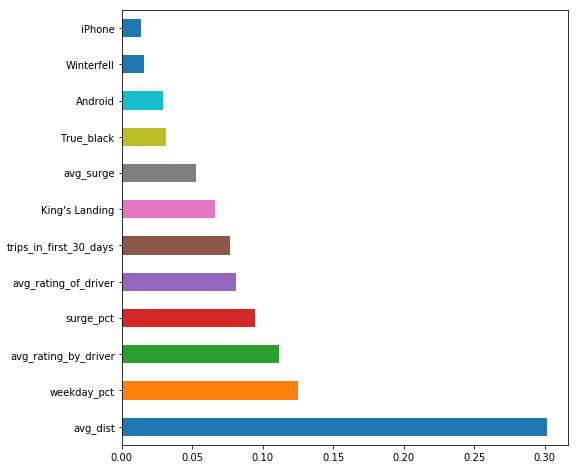

In [98]:
plt.figure(figsize = (8, 8))
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [106]:
#New feature for total distance covered in the first 30 days
df_upsampled['total_dist_first_30'] = df_upsampled.trips_in_first_30_days * df_upsampled.avg_dist

In [107]:
X = df_upsampled.drop(['retained'], axis=1)
y = df_upsampled['retained']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Instantiate model with 250 decision trees
rf = RandomForestClassifier(random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train)

X_test = X_test[X_train.columns.tolist()] # Added to refelct the column count

y_pred2 = rf.predict(X_test)

roc2 = roc_auc_score(y_test, y_pred2)

roc2

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8477286797514543

In [108]:
conf2 = confusion_matrix(y_test, y_pred2)
conf2

array([[7707, 1822],
       [1075, 8410]])

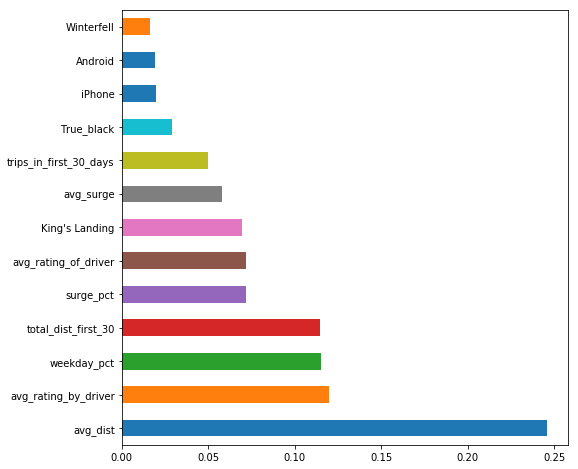

In [109]:
plt.figure(figsize = (8, 8))
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [100]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [110]:
# Use the random grid to search for best hyperparameters

# Random search of parameters, using 3 fold cross validation, 
# search across 30 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 30, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 13.8min
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 51.3min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=30, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [113]:
rf_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 110,
 'bootstrap': True}

In [115]:
# Instantiate model with 250 decision trees
rf = RandomForestClassifier(n_estimators= 1400,min_samples_split= 2,min_samples_leaf= 1,max_features= 'auto',\
                            max_depth= 110, bootstrap= True, random_state = 42)

# Train the model on training data
rf.fit(X_train, y_train)

X_test = X_test[X_train.columns.tolist()] # Added to refelct the column count

y_pred2 = rf.predict(X_test)

roc2 = roc_auc_score(y_test, y_pred2)

roc2

0.8553500390257789

In [116]:
conf2 = confusion_matrix(y_test, y_pred2)
conf2

array([[7582, 1947],
       [ 806, 8679]])

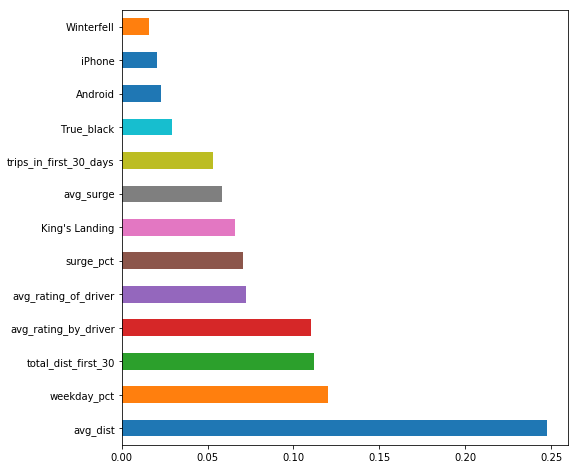

In [117]:
plt.figure(figsize = (8, 8))
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

## Interesting takeaways:

### * Built model can predict a rider retainment with an accuracy of about 85.5% given the available parameters
### * Early interactions with the app seem to be large dictators of fs a strong courther adoption. Those who took shorter trips to begin (perhaps more local trips) tend to stay on the service for longer. Similarly, having taken early rides on weekdays has a strong impact on continued use of the service. 
### * The created variable to total distance taken in the first 30 days also has a strong correlation to the outcome of retaining the service.

## Recommendations:

### * Incentivize early rides - perhaps focusing on weekdays ridership
### * make sure these incentives are offered for multiple rides as opposed to a single ride
### * Since rides in King's landing are already more likely to retain ridership, perhaps incentives will go a longer way in the other cities
### * Use the of the black car service is positively correlated with continued use of the platform. Could there be an incentive for the use of this type of service?

In [ ]:
# Parameters:

# city: city this user signed up in
# phone: primary device for this user
# signup_date: date of account registration; in the form ‘YYYYMMDD’
# last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
# avg_dist: the average distance in miles per trip taken in the first 30 days after signup
# avg_rating_by_driver: the rider’s average rating over all of their trips
# avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
# surge_pct: the percent of trips taken with surge multiplier > 1
# avg_surge: The average surge multiplier over all of this user’s trips
# trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
# ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
# weekday_pct: the percent of the user’s trips occurring during a weekday